# Text-To-Speech(TTS) Demo

This notebook is intended to demonstrate the TTS component of the audio reader. Please feel free to try out TTS engine within this notebook, which provide simple code that allow you to generate speech in multiple language, adjustable speed, and by mulitple backends.It is better to pass all cases before moving on to the AI reader application.😊

### Introduction about the model

Text-To-Speech(TTS) has been a very active field in AI research. The task usually takes a piece of text as input and output the wave form of this speech. In addition, in many cases people are interested in controling the tone of the speech with some reference speech, and this task is called voice cloning. There are two variant of voice cloning: zero-shotand few-shot. Zero-shot voice cloning uses around 5s reference speech and don't
require gradient propagation, which mean this can clone on fly. Few-shot cloning uses around 1min refence speech as a finetune dataset, and is possible to capture the speaker's voice feature more vividly.

In our project, we use a model called GPT-SoVITS(https://github.com/RVC-Boss/GPT-SoVITS), a trending TTS model in the Chinese AI community recently. With relatively small model size, GPT-SoVITS is both capable of producing high quality speeches on zero-shot and few-shot voice cloning tasks.

Regarding the structure, GPT-SoVITS combine two popular TTS model: VALL-E and VITS, which is respectively stage 1 and stage2. In the first stage, given text to convert, reference sound and its corresponding text, the model transform them into discrete tokens, and utilizes a autoregressive transformer to predict the sound tokens of the target speech(This is where "GPT" in the project's name come from). This strategy is initially proposed by VALL-E (https://github.com/lifeiteng/vall-e) and later widely adopted.

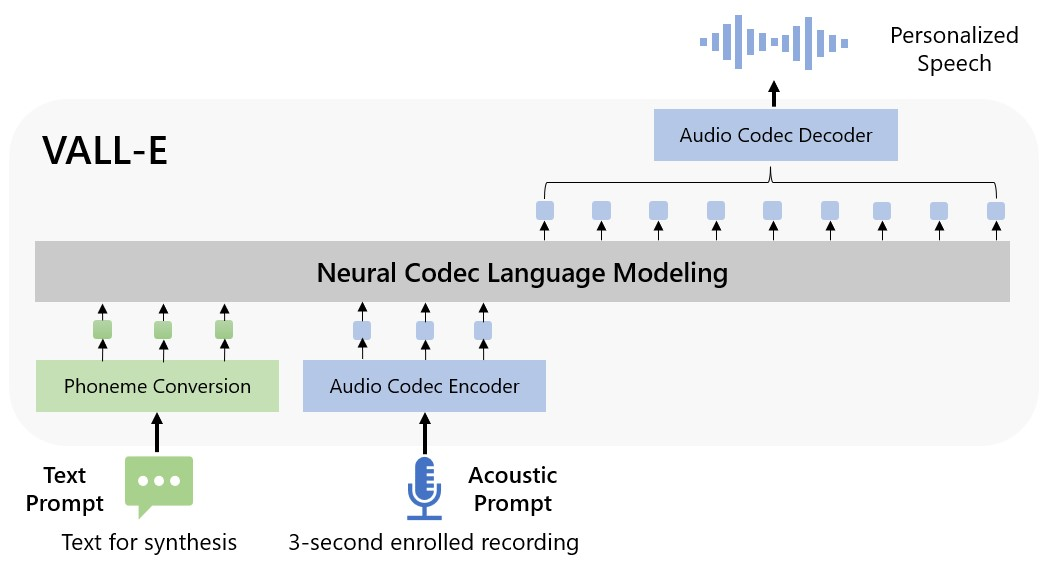

For VALL-E, the discrete sound tokens are produced from VQGAN trained on audio pieces ( Encodec https://github.com/facebookresearch/encodec), and token predicted by the casual transformer is mapped back to wave form through the VQGAN decoder. However, studies show TTS performance are often constrained by the VQ decoder. What's innovative about GPT-SoVITS is that is uses VITS as the discrete token decoder, which is originally capable of generate sound with high efficiency. Stacking two model together might seems redundant at first sight, but according to the project developer, this structure is effective through experiments.

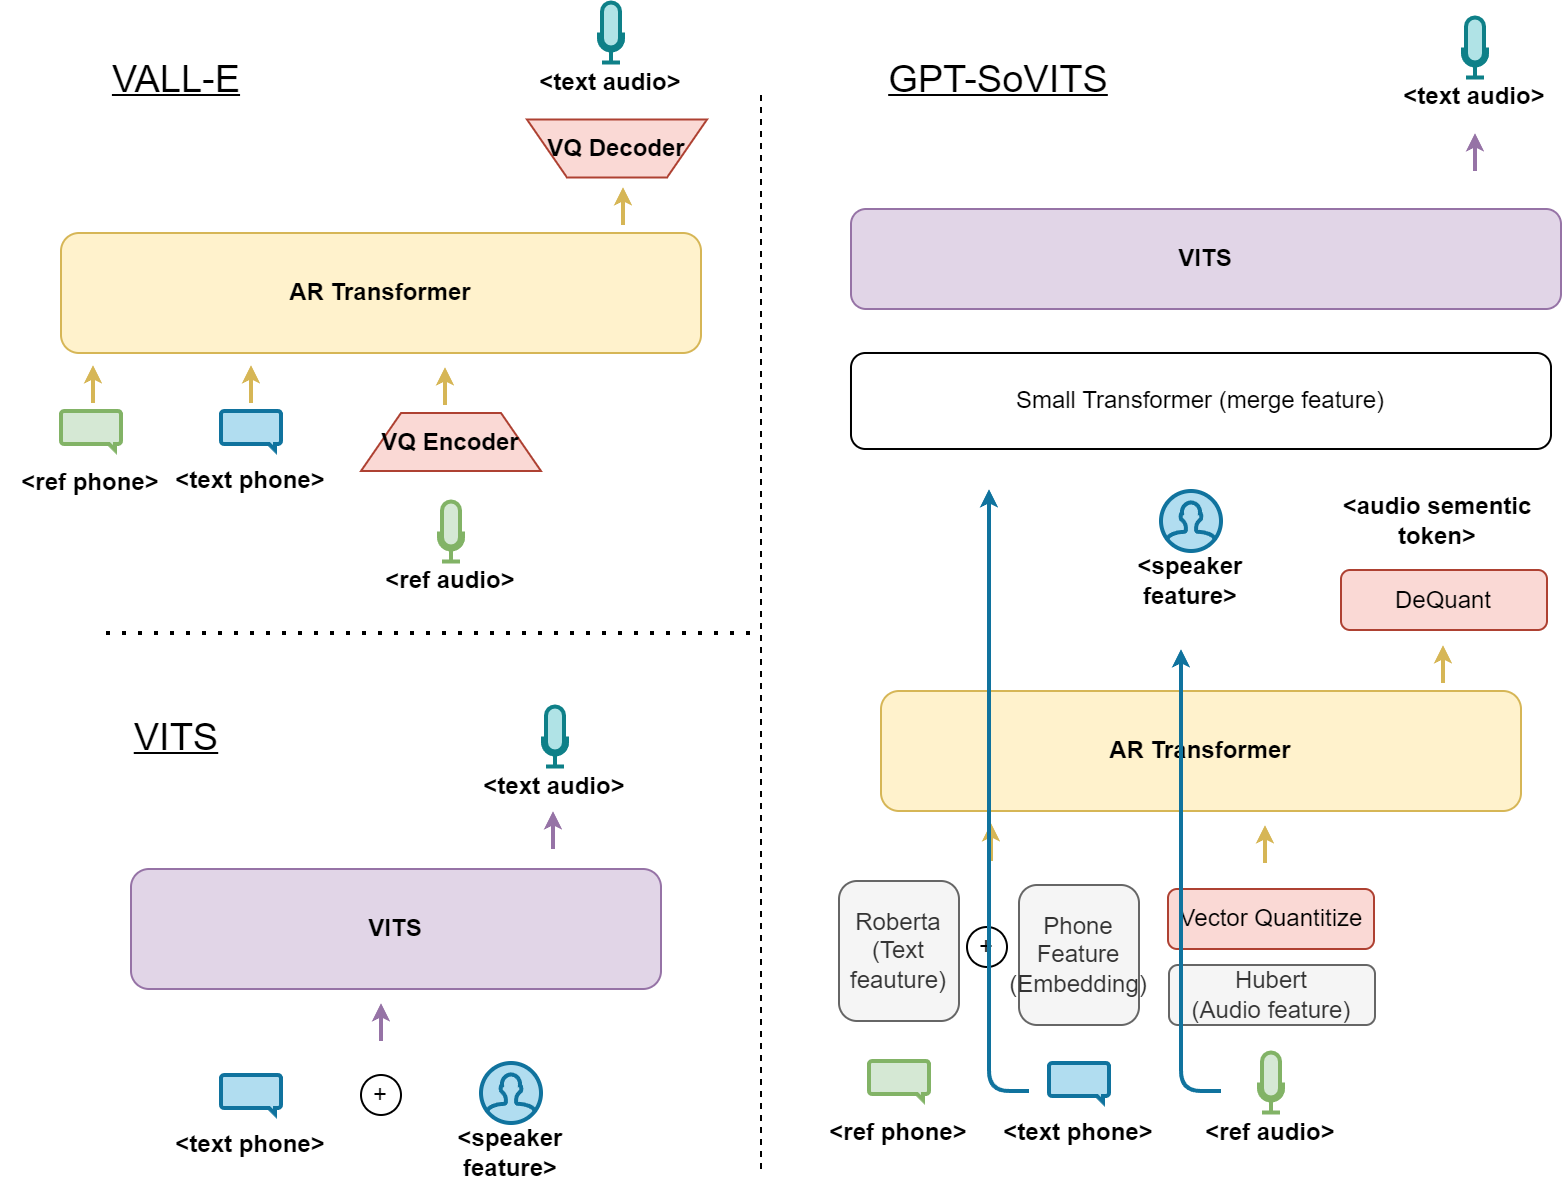

The flow chart above compare the difference between VALL-E, VITS and GPT-SoVITS. It is obvious that GPT-SoVITS uses significantly more modules, including pretrain models like Hubert, Roberta-Large. 

### Using GPT-SoVITS in Pytorch

First of all, let's look at running GPT-SoVITS in pytorch. These code are modified from the GPT-SoVITS's original project.

Remember that GPT-SoVITS is a zero-shot voice cloning model, so a piece of reference audio is needed. We choose [数据堂—150人中文客服平均音色合成库(150 average mandarin speech dataset)](https://www.modelscope.cn/datasets/DatatangBeijing/150People-ChineseMandarinAverageToneSpeechSynthesisCorpus-CustomerService), containing 450 short utterance for customer service with high speech quality.

In [1]:
from Service150 import UtterDs
from gpt_sovits import func_api
from IPython.display import Audio

#load reference audio dataset
ds = UtterDs("./Service150")

REFERENCE_ID = 105 # 0~449
# load a reference audio
ref_wav_path, prompt_text = ds[REFERENCE_ID]


print(prompt_text)
Audio(ref_wav_path, rate=16000)

c:\Users\a2576\.conda\envs\tts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\a2576\.conda\envs\tts\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


那您现在需要办理吗，想办吗？


Now, load the model

In [2]:
PATH = {
    "cnhubert_path":"./cache/GPT_SoVITS/pretrained_models/chinese-hubert-base",
    "bert_path":"./cache/GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large",
    "vits_path":"./cache/GPT_SoVITS/pretrained_models/s2G488k.pth",
    "gpt_path":"./cache/GPT_SoVITS/pretrained_models/s1bert25hz-2kh-longer-epoch=68e-step=50232.ckpt"
}
func_api.init_model(PATH)

c:\Users\a2576\.conda\envs\tts\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of the model checkpoint at ./cache/GPT_SoVITS/pretrained_models/chinese-hubert-base were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the mo

sovits版本: v1
INFO:root:Number of parameter: 77.49M


In [4]:
# TTS
# Chinese(zh), Enlish(en) and Japanese(ja) TTS are all supported!

text = """
The 2024 Summer Olympics, officially the Games of the XXXIII Olympiad and branded as Paris 2024, 
is an international multi-sport event taking place from 24 July to 11 August 2024 in France.
"""
text_language = "en"


wav_output = func_api.get_tts_wav(
    ref_wav_path=ref_wav_path,
    prompt_text= prompt_text,
    prompt_language="zh",
    text=text,
    text_language=text_language
)

Audio(wav_output, rate=func_api.hps.data.sampling_rate)

 16%|█▌        | 234/1500 [00:05<00:30, 41.51it/s]


T2S Decoding EOS [85 -> 320]


 13%|█▎        | 200/1500 [00:04<00:30, 42.13it/s]


T2S Decoding EOS [85 -> 286]


### Using GPT-SoVITS with onnx and npu




In [2]:
# Define the environment variable for NPU


import os
PWD=".\\ryzen-ai\\transformers"
os.environ["THIRD_PARTY"] = f"{PWD}\\third_party"
os.environ["TVM_LIBRARY_PATH"] = f"os.environ['TVM_LIBRARY_PATH']\\lib;{os.environ['THIRD_PARTY']}\\bin"

os.environ["PATH"]=f"{os.environ['PATH']};{os.environ['TVM_LIBRARY_PATH']};{PWD}\\ops\\cpp\\;{os.environ['THIRD_PARTY']}" 
os.environ["PYTORCH_AIE_PATH"] = f"{PWD}"

os.environ["PYTORCH_AIE_PATH"] = f"{PWD}"
os.environ["XRT_PATH"] = f"os.environ['THIRD_PARTY']\\xrt"
os.environ["DEVICE"] = f"phx"
os.environ["XLNX_VART_FIRMWARE"] = f"{PWD}\\xclbin\\phx"

os.environ["TVM_MODULE_PATH"] = f"{PWD}\\dll\\phx\\qlinear\\libGemmQnnAie_1x2048_2048x2048.dll,{PWD}\\dll\\phx\\qlinear\\libGemmQnnAie_8x2048_2048x2048.dll,"
os.environ["TVM_GEMM_M"] = f"1,8,"
os.environ["TVM_DLL_NUM"] = f"2"



In [3]:
!echo %PYTORCH_AIE_PATH%

.\ryzen-ai\transformers


In [4]:
from tts_engine import TTSEngine
from IPython.display import Audio

REFERENCE_ID = 105 # 0~449
DEVICE = "npu" # or "npu"
SPEED = 1.0

text = """Most of the Olympic events are being held in the city of Paris and its metropolitan region, 
including the neighbouring cities of Saint-Denis, Le Bourget, Nanterre, Versailles, and Vaires-sur-Marne.
"""


engine = TTSEngine(REFERENCE_ID, DEVICE)
audio = engine.tts(text, SPEED, "zh")
Audio(audio, rate=32000)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


=============   clean cache  =============

done loading onnx model


  8%|▊         | 125/1500 [00:11<02:03, 11.16it/s]


torch.Size([1, 1, 126])


 15%|█▌        | 226/1500 [00:19<01:52, 11.33it/s]


torch.Size([1, 1, 227])
